# Pre-processing

In [20]:
"""
1. remove duplicate records： user-item
2. remove users with less tha (2, 3) items
3. find overlapping users 
4. remap users and items and save overlapped users to pickle files. 
5. cross domain cold-start datasets splits and save to txt
6. cross-domain recommendation datasets splits and save data to txt files
"""
import os
import json
import gzip
import pandas as pd
from urllib.request import urlopen
import _pickle as pickle
import gc


def pickle_save(data, file):
    with open(file, "wb") as fid:
        pickle.dump(data, fid)

        
def pickle_load(file):
    return pickle.load(open(file, 'rb'))


def list2dict(list_data):
    result = {}
    for ind, val in enumerate(list_data): 
        result[val] = ind
    return result


def load_df(data_path, user_id=None):
    data = []  
    keys = ["reviewerID", "overall", "asin"]  # get only user item and rating. 
    with gzip.open(data_path) as f:
        for l in f:    
            tmp = {}
            a= json.loads(l.strip())
            if user_id is not None and a['reviewerID'] not in user_id:
                # load data points for only selected users (in user_id)
                continue                 
            for key in keys:
                tmp[key] = a[key]
            data.append(tmp)    
    df = pd.DataFrame.from_dict(data)
    print(len(df))
    # save
    # df.to_csv(data_path.split('.')[0] + f"_{num_domain}.csv", index=False)
    return df


def remove_dup(df):
    '''
    Remove duplications
    '''
    df['user_item'] = df["reviewerID"] + df['asin']  # new column
    
    tmp1 = df.groupby(['user_item'], as_index=False)['asin'].count()
    tmp1.rename(columns={'asin': 'cnt_over'}, inplace=True)
    df = df.merge(tmp1, on=['user_item']) 
    query = "cnt_over <= 1"  # remove duplicates
    df = df.query(query).reset_index(drop=True).copy()
    df.drop(['cnt_over'], axis=1, inplace=True)
    df.drop(['user_item'], axis=1, inplace=True)
    del tmp1
    gc.collect()
    return df


def user_limit(df, k=2):
    tmp1 = df.groupby(['reviewerID'], as_index=False)['asin'].count()
    tmp1.rename(columns={'asin': 'cnt_item'}, inplace=True)
    df = df.merge(tmp1, on=['reviewerID']) 
    query = "cnt_item >= %d" % (k)
    df = df.query(query).reset_index(drop=True).copy()
    df.drop(['cnt_item'], axis=1, inplace=True)
    del tmp1
    gc.collect()
    return df    


def main_clear(file):
    df = load_df(file)
    df = remove_dup(df)
    df = user_limit(df)
    return df 

In [49]:
'''
Clear and get users 
remove duplications (u,v)

'''
Path = '/data/ceph/seqrec/UMMD/data/amazon'
files = ["Books.json.gz", "Electronics.json.gz", "Sports_and_Outdoors.json.gz", 
         "Movies_and_TV.json.gz", "Video_Games.json.gz"]
users = [] 

for file in files:
    df = main_clear(os.path.join(Path, file))
    users.append(set(df['reviewerID']))
    df.to_csv(os.path.join(Path, f"{file.split('.')[0]}.csv"), index=False)
    

51311621
20994353
12980837
8765568
2565349


In [50]:
# find overlapping users
def find_intersects(data_users):
    result = set(data_users[0])
    for val in data_users[1:]:
        result = result.intersection(set(val))
    return result


selected_users = find_intersects(users)  # 18347

In [51]:
# save new df with selected users. 
pickle_save(list2dict(list(selected_users)), os.path.join('/data/ceph/seqrec/UMMD/data/amazon_p/selected_user.pickle'))

In [52]:
'''
load only selected users
'''

def load_selected(file, select_user):
    df = pd.read_csv(file)
    result = {'uid': [], 'item': [], 'rate': []}
    for index, row in df.iterrows():
        if row['reviewerID'] in select_user:
            result['uid'].append(row['reviewerID'])
            result['item'].append(row['asin'])
            result['rate'].append(row['overall'])
    df = pd.DataFrame(result)
    df.to_csv(file.split(".")[0] + "_selected.csv", index=False)
    

Path = '/data/ceph/seqrec/UMMD/data/amazon'
files = ["Books.csv", "Electronics.csv", "Sports_and_Outdoors.csv", "Movies_and_TV.csv", "Video_Games.csv"]

for file in files:
    load_selected(os.path.join(Path, file), selected_users)

In [53]:
'''
remap user and item IDs 
'''
def remap(file, user_dict_file, outfile):
    user_dict = pickle_load(user_dict_file)
    df = pd.read_csv(file)
    item_dict = list2dict(list(set(df['item'])))
    pickle_save(item_dict, outfile.split(".")[0] + "_ItemRemap.pickle")
    
    result = {}
    for index, row in df.iterrows():
        remapped_uid = user_dict[row['uid']]
        remapped_item = item_dict[row['item']]
        rate = float(row['rate']) 
        
        if remapped_uid not in result: 
            result[remapped_uid] = [[remapped_item], [rate]]
        else:
            result[remapped_uid][0].append(remapped_item)
            result[remapped_uid][1].append(rate)
    print(f"number of users {len(result)}")
    final = {'uid': [], "item": [], "rate": []}
    for key in result.keys():
        final['uid'].append(key)
        final['item'].append(result[key][0])
        final['rate'].append(result[key][1])
    df = pd.DataFrame(final)
    df.to_csv(outfile, index=False)

        

In [54]:
Path = '/data/ceph/seqrec/UMMD/data/amazon'
files = ["Books_selected.csv", "Electronics_selected.csv", "Sports_and_Outdoors_selected.csv",  
         "Movies_and_TV_selected.csv", "Video_Games_selected.csv"]
out_path = "/data/ceph/seqrec/UMMD/data/amazon_p"

for file in files:
    remap(os.path.join(Path, file), 
          '/data/ceph/seqrec/UMMD/data/amazon_p/selected_user.pickle', 
          os.path.join(out_path, file))
    

number of users 18347
number of users 18347
number of users 18347
number of users 18347
number of users 18347


In [55]:
book_select = pd.read_csv("/data/ceph/seqrec/UMMD/data/amazon/Books_selected.csv")

In [56]:
print(len(book_select))
print(book_select.head())

573935
              uid        item  rate
0  A2NJO6YE954DBH  0001712799   4.0
1  A2NJO6YE954DBH  0001716069   4.0
2  A2NJO6YE954DBH  0001712764   5.0
3  A2NJO6YE954DBH  0002005549   3.0
4  A2NJO6YE954DBH  0002213311   4.0


In [57]:
book_select = pd.read_csv("/data/ceph/seqrec/UMMD/data/amazon_p/Books_selected.csv")
print(len(book_select))
print(book_select.head())

18347
     uid                                               item  \
0  13523  [99831, 110332, 133848, 100809, 207595, 61988,...   
1  17261  [99831, 133848, 245227, 153456, 156560, 256063...   
2   5774  [99831, 35598, 94514, 241750, 91860, 63024, 13...   
3   3754  [238152, 2691, 189103, 66620, 216859, 13110, 1...   
4  15518  [238152, 267568, 739, 142513, 171633, 171495, ...   

                                                rate  
0  [4.0, 4.0, 5.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...  
1  [3.0, 2.0, 3.0, 5.0, 5.0, 5.0, 5.0, 2.0, 5.0, ...  
2  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...  
3  [1.0, 2.0, 1.0, 4.0, 5.0, 4.0, 1.0, 5.0, 5.0, ...  
4  [3.0, 5.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, ...  


# CSV to Text final dataset: cold-start


In [13]:
# train and test split 
import numpy as np
import matplotlib.pyplot as plt
import copy


def update_p(in_val):
    val_def = [4.0 / 4, 2 / 4.0, 1.25 / 4, 0.75 / 4, 0]
    ind = val_def.index(in_val)
    return val_def[ind + 1]

def normalize_prob(prob):
    return prob / float(np.sum(prob))


def user_splits_cold_start(user_list, cold_rate, dense_rate):
    assert cold_rate + dense_rate < 0.9 
    # set aside the dense users. 
    total_num = len(user_list)
    dense_users = np.random.choice(user_list, int(total_num * dense_rate), replace=False)
    left_users = [val for val in user_list if val not in dense_users]
    
    # selected cold start users for each domain
    total_cold = len(left_users)
    p = np.ones(len(left_users)) 
    domain_cold = []
    selected_sets = {} 
    for i in range(5): # domains        
        prob = normalize_prob(p)
        selected_tmp = np.random.choice(left_users, int(total_num * cold_rate), replace=False, p=prob)
        domain_cold.append(selected_tmp)
        for val in selected_tmp:
            index = left_users.index(val)
            old_p = copy.deepcopy(p[index])
            # print(index, old_p)
            new = update_p(old_p)
            # print(new)
            p[index] = copy.deepcopy(new)
            # print(index, p[index], new)
            # p[left_users.index(val)] -= 1
            if val in selected_sets:
                selected_sets[val] += 1
            else:
                selected_sets[val] = 1
    return selected_sets, domain_cold, dense_users

In [14]:
user_list = list(np.arange(18347))
selected_sets, domain_cold, dense_users = user_splits_cold_start(user_list, 0.2, 0.5)
print(len(selected_sets), len(dense_users))

9051 9173


In [15]:
pickle_save(selected_sets, f'/data/ceph/seqrec/UMMD/data/amazon_p/cold_start/selected_sets_{0.2 * 10}_{0.5 * 10}.pickle')   
pickle_save(domain_cold, f'/data/ceph/seqrec/UMMD/data/amazon_p/cold_start/domain_cold_{0.2 * 10}_{0.5 * 10}.pickle')   
pickle_save(dense_users, f'/data/ceph/seqrec/UMMD/data/amazon_p/cold_start/dense_users_{0.2 * 10}_{0.5 * 10}.pickle')   

[1 2 3 4]


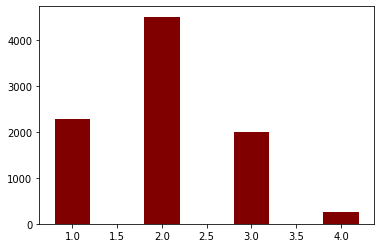

In [16]:
'''
整体分布
'''
values = np.array(list(selected_sets.values()))
unique, counts = np.unique(values, return_counts=True)
print(unique)
plt.bar(unique, counts, color ='maroon', width = 0.4)
plt.show()

3669
[1 2 3 4]


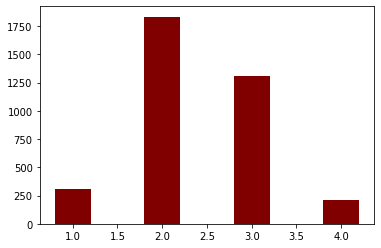

In [17]:
'''
单个域cold user的分布情况 
'''
values = []
domain = 4
for val in domain_cold[domain]:
    values.append(selected_sets[val])
print(len(values))
unique, counts = np.unique(values, return_counts=True)
print(unique)
plt.bar(unique, counts, color ='maroon', width = 0.4)
plt.show()

5505
[0 1 2 3 4]


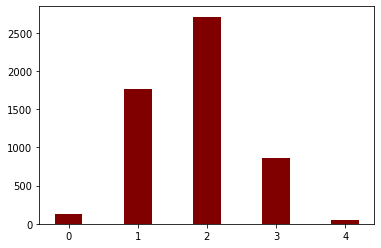

In [18]:
'''
单个域非cold user的分布情况 
'''
values = []
domain = 0
for val in user_list:
    if val not in dense_users and val not in domain_cold[domain]:
        if val in selected_sets:
            values.append(selected_sets[val])
        else:
            values.append(0)
print(len(values))

unique, counts = np.unique(values, return_counts=True)
print(unique)
plt.bar(unique, counts, color ='maroon', width = 0.4)
plt.show()

In [55]:
''' 
Split cold-start and train users 
Train user data are further split into train and valid parts
'''


def str2list(strdata): 
    pass


def split_cold(df, user_map, cold_user, valid_rate): 
    cold_result = {'uid': [], 'item': [], 'rate': []}
    train_result = {'uid': [], 'item': [], 'rate': []}
    valid_result = {'uid': [], 'item': [], 'rate': []}
    
    #     cold_index = []
    #     for val in cold_user:  # ID2index
    #         cold_index.append(user_map[val])
    
    for index, row in df.iterrows():
        if row['uid'] in cold_user:   # cold_user --> cold_index if user_id in cold_users
            cold_result['uid'].append(row['uid'])
            cold_result['item'].append(row['item'])
            cold_result['rate'].append(row['rate'])
        else:
            train_result['uid'].append(row['uid'])
            valid_result['uid'].append(row['uid'])
            # train valid splits
            items = eval(row['item'])
            rates = eval(row["rate"])
            # print(items, type(items), rates, type(rates))
            # print(items, type(items), eval(items), type(eval(items)))
            # sys.exit()        
            zipped = list(zip(items, rates))
            np.random.shuffle(zipped)                          # seed ? 
            items, rates = zip(*zipped)
            items, rates = list(items), list(rates)
            
            valid_num = int(len(items) * valid_rate)
            if valid_num == 0 :
                valid_num = 1
            # print(items[0: -valid_num], str(items[0: -valid_num]), type(str(items[0: -valid_num])) )
            # sys.exit()
            train_result['item'].append(str(items[0: -valid_num]))
            train_result['rate'].append(str(rates[0: -valid_num]))
            
            valid_result['item'].append(str(items[-valid_num:]))
            valid_result['rate'].append(str(rates[-valid_num:]))
            
    return cold_result, train_result, valid_result


def Dict2Csv(data, filename):
    df_tmp = pd.DataFrame(data)
    print(df_tmp.head(), len(df_tmp))
    df_tmp.to_csv(filename, index=False)
    

def main_cold(path, cold_file, valid_rate, files, file_id): 
    data_file = files[file_id]
    df = pd.read_csv(os.path.join(path, data_file))
    user_map = pickle_load(os.path.join(path, "selected_user.pickle"))
    cold_index = files.index(data_file)
    cold = pickle_load(os.path.join(path, 'cold_start', cold_file))[cold_index]
    
    cold_data, train_data, valid_data = split_cold(df, user_map, cold, valid_rate)
    # save cold_data
    print("==== cold users")
    Dict2Csv(cold_data, os.path.join(path, 'cold_start', data_file.split("_")[0] + "_cold.csv"))
    print("==== train data")
    Dict2Csv(train_data, os.path.join(path, 'cold_start', data_file.split("_")[0] + "_train.csv"))
    print("==== valid_data")
    Dict2Csv(valid_data, os.path.join(path, 'cold_start', data_file.split("_")[0] + "_valid.csv"))


In [56]:
files = ["Books_selected.csv", "Electronics_selected.csv", "Sports_and_Outdoors_selected.csv",  
             "Movies_and_TV_selected.csv", "Video_Games_selected.csv"]
valid_rate = 0.2
for i in range(len(files)):
    print(f" *************** {files[i]}")
    main_cold('/data/ceph/seqrec/UMMD/data/amazon_p',                
              "domain_cold_2.0_5.0.pickle", 
              valid_rate, files, i)

 *************** Books_selected.csv
==== cold users
     uid                                               item  \
0  13523  [99831, 110332, 133848, 100809, 207595, 61988,...   
1  15902  [238152, 100809, 97460, 122587, 61698, 46657, ...   
2   2553  [222305, 201265, 204887, 122008, 98409, 128563...   
3  11886  [222305, 173698, 14697, 238139, 40228, 233866,...   
4   3391  [222305, 234147, 101033, 247155, 130199, 62459...   

                                                rate  
0  [4.0, 4.0, 5.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, ...  
1  [4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ...  
2           [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]  
3  [5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...  
4  [4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, ...   3669
==== train data
     uid                                               item  \
0  17261  [205554, 265246, 156560, 156, 250893, 228262, ...   
1   5774  [136232, 99831, 208047, 35598, 63024, 13037, 1...   
2   3754  [206257, 61864, 200

# Cross-Domain Enhancement Dataset

In [66]:
'''
two cases: 
    1. random remove part of users in each domains
    2. just train valid and test split of the data for each users.  
'''

def split_cdr(df, valid_rate, test_rate): 
    test_result = {'uid': [], 'item': [], 'rate': []}
    train_result = {'uid': [], 'item': [], 'rate': []}
    valid_result = {'uid': [], 'item': [], 'rate': []}
    
    for index, row in df.iterrows():
        train_result['uid'].append(row['uid'])
        test_result['uid'].append(row['uid'])
        
        # train test splits
        items = eval(row['item'])
        rates = eval(row["rate"])
        zipped = list(zip(items, rates))
        np.random.shuffle(zipped)  
        items, rates = zip(*zipped)
        items, rates = list(items), list(rates)
        
        test_num = int(len(items) * test_rate)
        if test_num == 0 :
            test_num = 1
    
        valid_num = int((len(items) - test_num) * test_rate)
        if valid_num == 0 and (len(items) - test_num) > 1:
            valid_num = 1
        else: # this user is not used in valid
            pass
        
        train_result['item'].append(str(items[0: -(valid_num + test_num)]))
        train_result['rate'].append(str(rates[0: -(valid_num + test_num)]))
        
        test_result['item'].append(str(items[-(valid_num + test_num): -valid_num]))
        test_result['rate'].append(str(rates[-(valid_num + test_num): -valid_num]))
        
        if valid_num != 0:
            valid_result['uid'].append(row['uid'])
            valid_result['item'].append(str(items[-valid_num:]))
            valid_result['rate'].append(str(rates[-valid_num:]))
            
    return test_result, train_result, valid_result


def main_cdr(path, valid_rate, test_rate, files, file_id): 
    data_file = files[file_id]
    df = pd.read_csv(os.path.join(path, data_file))    
    test_data, train_data, valid_data = split_cdr(df, valid_rate, test_rate)
    # save cold_data
    print("==== cold users")
    Dict2Csv(test_data, os.path.join(path, 'CDR', data_file.split("_")[0] + "_test.csv"))
    print("==== train data")
    Dict2Csv(train_data, os.path.join(path, 'CDR', data_file.split("_")[0] + "_train.csv"))
    print("==== valid_data")
    Dict2Csv(valid_data, os.path.join(path, 'CDR', data_file.split("_")[0] + "_valid.csv"))

In [67]:
files = ["Books_selected.csv", "Electronics_selected.csv", "Sports_and_Outdoors_selected.csv",  
             "Movies_and_TV_selected.csv", "Video_Games_selected.csv"]
valid_rate = 0.15
test_rate = 0.2

for i in range(len(files)):
    print(f" *************** {files[i]}")
    main_cdr('/data/ceph/seqrec/UMMD/data/amazon_p', valid_rate, test_rate,  files, i)

 *************** Books_selected.csv
==== cold users
     uid                                               item  \
0  13523  [132523, 99414, 80703, 254149, 26751, 7181, 17...   
1  17261  [134519, 7324, 14584, 32698, 163626, 99831, 25...   
2   5774                                   [136232, 166214]   
3   3754  [259023, 131144, 251466, 255167, 6809, 140897,...   
4  15518  [211831, 169895, 84358, 127602, 182005, 61604,...   

                                                rate  
0  [5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, ...  
1                [3.0, 5.0, 5.0, 3.0, 5.0, 3.0, 4.0]  
2                                         [5.0, 5.0]  
3  [4.0, 1.0, 4.0, 4.0, 5.0, 5.0, 2.0, 5.0, 5.0, ...  
4  [3.0, 4.0, 2.0, 4.0, 4.0, 2.0, 4.0, 3.0, 5.0, ...   18347
==== train data
     uid                                               item  \
0  13523  [29416, 202340, 271982, 142503, 245979, 130577...   
1  17261  [205554, 30000, 3509, 149469, 100716, 248563, ...   
2   5774  [63024, 45420, 998

In [6]:
df.head()

,reviewerID,overall,asin
0,A1MN8PP39IIB7N,5.0,0439381673
1,A9OSOC53QERJ1,5.0,0439381673
2,A1OT385HNQ7KVP,1.0,0439381673
3,A2LK3J4OAGFJ7L,5.0,0700026657
4,A1YJWEXHQBWK2B,3.0,0700026657


In [7]:
df['user_item'] = df["reviewerID"] + df['asin']

In [8]:
df

,reviewerID,overall,asin,user_item
0,A1MN8PP39IIB7N,5.0,0439381673,A1MN8PP39IIB7N0439381673
1,A9OSOC53QERJ1,5.0,0439381673,A9OSOC53QERJ10439381673
2,A1OT385HNQ7KVP,1.0,0439381673,A1OT385HNQ7KVP0439381673
3,A2LK3J4OAGFJ7L,5.0,0700026657,A2LK3J4OAGFJ7L0700026657
4,A1YJWEXHQBWK2B,3.0,0700026657,A1YJWEXHQBWK2B0700026657
...,...,...,...,...
292514,ARWBMMS40O03Z,5.0,B01HI8JR82,ARWBMMS40O03ZB01HI8JR82
292515,A34GG58TJ1A3SH,4.0,B01HIZF7XE,A34GG58TJ1A3SHB01HIZF7XE
292516,AS6J0XKQMULAT,5.0,B01HIZF7XE,AS6J0XKQMULATB01HIZF7XE
292517,A3HQRH4RQOZ1PO,5.0,B01HIZF7XE,A3HQRH4RQOZ1POB01HIZF7XE


In [9]:
tmp1 = df.groupby(['user_item'], as_index=False)['asin'].count()

In [11]:
tmp1.rename(columns={'asin': 'cnt_over'}, inplace=True)

In [12]:
df = df.merge(tmp1, on=['user_item']) 

In [13]:
df

,reviewerID,overall,asin,user_item,cnt_over
0,A1MN8PP39IIB7N,5.0,0439381673,A1MN8PP39IIB7N0439381673,1
1,A9OSOC53QERJ1,5.0,0439381673,A9OSOC53QERJ10439381673,1
2,A1OT385HNQ7KVP,1.0,0439381673,A1OT385HNQ7KVP0439381673,1
3,A2LK3J4OAGFJ7L,5.0,0700026657,A2LK3J4OAGFJ7L0700026657,1
4,A1YJWEXHQBWK2B,3.0,0700026657,A1YJWEXHQBWK2B0700026657,1
...,...,...,...,...,...
292514,ARWBMMS40O03Z,5.0,B01HI8JR82,ARWBMMS40O03ZB01HI8JR82,1
292515,A34GG58TJ1A3SH,4.0,B01HIZF7XE,A34GG58TJ1A3SHB01HIZF7XE,1
292516,AS6J0XKQMULAT,5.0,B01HIZF7XE,AS6J0XKQMULATB01HIZF7XE,1
292517,A3HQRH4RQOZ1PO,5.0,B01HIZF7XE,A3HQRH4RQOZ1POB01HIZF7XE,1


In [15]:
query = "cnt_over <= 1"
df = df.query(query).reset_index(drop=True).copy()

In [16]:
df

,reviewerID,overall,asin,user_item,cnt_over
0,A1MN8PP39IIB7N,5.0,0439381673,A1MN8PP39IIB7N0439381673,1
1,A9OSOC53QERJ1,5.0,0439381673,A9OSOC53QERJ10439381673,1
2,A1OT385HNQ7KVP,1.0,0439381673,A1OT385HNQ7KVP0439381673,1
3,A2LK3J4OAGFJ7L,5.0,0700026657,A2LK3J4OAGFJ7L0700026657,1
4,A1YJWEXHQBWK2B,3.0,0700026657,A1YJWEXHQBWK2B0700026657,1
...,...,...,...,...,...
271739,ARWBMMS40O03Z,5.0,B01HI8JR82,ARWBMMS40O03ZB01HI8JR82,1
271740,A34GG58TJ1A3SH,4.0,B01HIZF7XE,A34GG58TJ1A3SHB01HIZF7XE,1
271741,AS6J0XKQMULAT,5.0,B01HIZF7XE,AS6J0XKQMULATB01HIZF7XE,1
271742,A3HQRH4RQOZ1PO,5.0,B01HIZF7XE,A3HQRH4RQOZ1POB01HIZF7XE,1


# Age and Gender dataset

In [62]:
path = "/data/ceph/seqrec/UMMD/data/pickle/q36_age_train_0"
out_path = "/data/ceph/seqrec/UMMD/data/pickle/q36_age_train"

AgeGender_dict = pickle_load('/data/ceph/seqrec/UMMD/data/pickle/q36_used_age_gender_dict.pickle')

files = [file for file in os.listdir(path) if "_0.pickle" in file]

for file in files:
    data = pickle_load(os.path.join(path, file))    
    data['age'] = []
    data['gender'] = []
    for ind, user in enumerate(data['uid']):
        if AgeGender_dict[user][0] != data['label'][ind]: 
            print("error")
            print(user, data['label'][ind], AgeGender_dict[user])
            print(file)
            break
        else:
            data['age'].append(AgeGender_dict[user][0])
            data['gender'].append(AgeGender_dict[user][1])
    pickle_save(data, os.path.join(out_path, file.split('.')[0] + ".pickle"))
    

In [57]:
data = pickle_load('/data/ceph/seqrec/UMMD/data/pickle/q36_age_train/part-00050.pickle')

In [59]:
data['age']

34

In [21]:


def num_inter_sparsity(file):
    df = pd.read_csv(file)
    num_inter = 0
    item_dict = set()
    for index, row in df.iterrows():
        item_list = eval(row['item'])
        num_inter += len(item_list)
        for val in item_list:
            item_dict.add(val)

    print(f"num of inter {num_inter}")
    return item_dict
    

In [22]:
book_set = num_inter_sparsity('/data/ceph/seqrec/UMMD/data/amazon_p/Books_selected.csv')

num of inter 573935


In [17]:
num_inter_sparsity('/data/ceph/seqrec/UMMD/data/amazon_p/Books_selected.csv')
num_inter_sparsity('/data/ceph/seqrec/UMMD/data/amazon_p/Electronics_selected.csv')
num_inter_sparsity('/data/ceph/seqrec/UMMD/data/amazon_p/Movies_and_TV_selected.csv')
num_inter_sparsity('/data/ceph/seqrec/UMMD/data/amazon_p/Sports_and_Outdoors_selected.csv')
num_inter_sparsity('/data/ceph/seqrec/UMMD/data/amazon_p/Video_Games_selected.csv')

num of inter 573935
num of inter 291639
num of inter 205801
num of inter 160365
num of inter 111213


In [18]:
data = pd.read_csv("/data/ceph/seqrec/UMMD/data/amazon_p/cold_start/Books_cold.csv")

In [19]:
data.head()

,uid,item,rate
0,13523,"[99831, 110332, 133848, 100809, 207595, 61988,...","[4.0, 4.0, 5.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, ..."
1,15902,"[238152, 100809, 97460, 122587, 61698, 46657, ...","[4.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, ..."
2,2553,"[222305, 201265, 204887, 122008, 98409, 128563...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
3,11886,"[222305, 173698, 14697, 238139, 40228, 233866,...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
4,3391,"[222305, 234147, 101033, 247155, 130199, 62459...","[4.0, 5.0, 3.0, 5.0, 5.0, 5.0, 5.0, 5.0, 3.0, ..."


In [27]:
book_selected = pd.read_csv('/data/ceph/seqrec/UMMD/data/amazon/Books_selected.csv')
book_itemmap = pickle_load('/data/ceph/seqrec/UMMD/data/amazon_p/Books_selected_ItemRemap.pickle')
book_final = pd.read_csv('/data/ceph/seqrec/UMMD/data/amazon_p/Books_selected.csv')
user_dict = pickle_load("/data/ceph/seqrec/UMMD/data/amazon_p/selected_user.pickle")

In [29]:
book_selected.head()

,uid,item,rate
0,A2NJO6YE954DBH,0001712799,4.0
1,A2NJO6YE954DBH,0001716069,4.0
2,A2NJO6YE954DBH,0001712764,5.0
3,A2NJO6YE954DBH,0002005549,3.0
4,A2NJO6YE954DBH,0002213311,4.0


In [30]:
book_final.head()

,uid,item,rate
0,13523,"[99831, 110332, 133848, 100809, 207595, 61988,...","[4.0, 4.0, 5.0, 3.0, 4.0, 4.0, 5.0, 5.0, 5.0, ..."
1,17261,"[99831, 133848, 245227, 153456, 156560, 256063...","[3.0, 2.0, 3.0, 5.0, 5.0, 5.0, 5.0, 2.0, 5.0, ..."
2,5774,"[99831, 35598, 94514, 241750, 91860, 63024, 13...","[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
3,3754,"[238152, 2691, 189103, 66620, 216859, 13110, 1...","[1.0, 2.0, 1.0, 4.0, 5.0, 4.0, 1.0, 5.0, 5.0, ..."
4,15518,"[238152, 267568, 739, 142513, 171633, 171495, ...","[3.0, 5.0, 5.0, 3.0, 4.0, 3.0, 3.0, 4.0, 4.0, ..."


In [31]:
user_dict['A2NJO6YE954DBH']

13523

In [33]:
book_itemmap['0001716069']

110332

# CSV2TXT

In [36]:
def csv2txt(filename, outfile): 
    data = pd.read_csv(filename)
    with open(outfile, "w") as fid:
        for ind, row in data.iterrows():
            val = []
            val.append(str(row['uid']))
            for item in eval(row['item']):
                val.append(str(item))
            val.append('\n')
            fid.write(' '.join(val))
        

In [37]:
csv2txt("/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_train.csv", "/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_train.txt")

In [38]:
csv2txt("/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_test.csv", "/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_test.txt")

In [67]:
train_data = pd.read_csv("/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_train.csv")

In [71]:
len(train_data)

18347

In [89]:
import numpy as np

data_set = AmazonSingleRec("/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_train.csv", 274552)

number of interaction 372870
Number of user 18347, 18346
Number of item 203458, 274551
13523 29416
13523 202340
13523 271982
13523 142503
13523 245979
13523 130577
13523 12239
13523 105337
13523 201434
13523 129326
13523 21798
13523 244492
13523 112311
13523 261839
13523 83031
13523 132836
13523 17620
13523 17484
13523 134669
13523 32228


In [75]:
train_data.head()

,uid,item,rate
0,13523,"[29416, 202340, 271982, 142503, 245979, 130577...","[5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, ..."
1,17261,"[205554, 30000, 3509, 149469, 100716, 248563, ...","[4.0, 3.0, 5.0, 5.0, 1.0, 2.0, 5.0, 2.0, 2.0, ..."
2,5774,"[63024, 45420, 99831, 91860, 241750, 35598, 20...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
3,3754,"[108151, 156778, 54617, 149460, 106828, 257253...","[4.0, 3.0, 3.0, 5.0, 3.0, 3.0, 4.0, 5.0, 5.0, ..."
4,15518,"[212215, 190273, 5182, 98325, 222418, 84894, 1...","[5.0, 3.0, 3.0, 4.0, 5.0, 1.0, 4.0, 5.0, 3.0, ..."


In [86]:
data_set.user_set

TypeError: 'int' object is not subscriptable

In [49]:
pip install torch 

Looking in indexes: https://mirrors.cloud.tencent.com/pypi/simple/
     |████████████████████████████████| 831.4 MB 25 kB/s  eta 0:00:01    |██                              | 51.0 MB 4.6 MB/s eta 0:02:50     |██▋                             | 66.8 MB 291 kB/s eta 0:43:39     |████████████▍                   | 322.3 MB 3.9 MB/s eta 0:02:10     |████████████▊                   | 330.5 MB 4.2 MB/s eta 0:02:01     |█████████████▍                  | 348.1 MB 3.7 MB/s eta 0:02:10     |███████████████████▏            | 497.9 MB 4.8 MB/s eta 0:01:09     |████████████████████▊           | 538.0 MB 4.6 MB/s eta 0:01:05     |████████████████████▉           | 542.4 MB 4.6 MB/s eta 0:01:04     |██████████████████████▏         | 575.8 MB 4.3 MB/s eta 0:01:00     |██████████████████████▎         | 579.6 MB 4.3 MB/s eta 0:00:59     |████████████████████████▋       | 639.2 MB 4.0 MB/s eta 0:00:48     |███████████████████████████▌    | 714.7 MB 4.4 MB/s eta 0:00:27     |██████████████████████████████▍ |

In [87]:
from torch.utils.data import DataLoader
import torch.utils.data as data

class AmazonSingleRec(data.Dataset):
    def __init__(self, filename, n_item, n_neg=1):
        """
        Args:
            filename: xxx.csv file with columns: 'uid', 'item', 'rate'
            n_neg:
            train:
        """
        self.n_neg = n_neg
        self.n_item = n_item
        self.uid = []
        self.pos = []
        self.user_item = {"user": [], "item": []}
        df = pd.read_csv(filename)
        for index, row in df.iterrows():
            self.user_item['user'].append(int(row['uid']))
            self.user_item['item'].append(eval(row['item']))
            for val in eval(row['item']):
                self.uid.append(int(row['uid']))
                self.pos.append(int(val))
        print(f'number of interaction {len(self.uid)}')
        self.item_set = list(set(self.pos))
        self.user_set = list(set(self.uid))
        print(f"Number of user {len(self.user_set)}, {np.max(self.user_set)}")
        print(f"Number of item {len(self.item_set)}, {np.max(self.item_set)}")
        for i in range(20):
            print(self.uid[i], self.pos[i])
        # sys.exit()

    def getUserPosItems(self, users):
        result = []
        for user_tmp in users:
            user_index = self.user_item['user'].index(user_tmp)
            result.append([user_tmp, self.user_item['item'][user_index]])
        return result

    def __getitem__(self, index):
        uid, pos = self.uid[index], self.pos[index]
        uid_index = self.user_item['user'].index(uid)
        while True:
            neg = random.sample(range(self.n_item), 1)
            if neg in self.user_item['item'][uid_index]:
                continue
            else:
                break

        return {"uid": np.array(uid), "pos": np.array([pos]), "neg": np.array(neg)}
        

    def __len__(self):
        return len(self.uid)


In [77]:
book_txt = open('/data/notebooks/jupyter-notebook/vq-graph/light-gcn/data/amazon-book/Books_train.txt')

In [78]:
book_l1 = book_txt.readline().strip().split(' ')

In [79]:
len(book_l1)

1160

In [80]:
book_l1[0]

'13523'

# Other tests

In [1]:
import pandas as pd

data = pd.read_csv("/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_test.csv")


In [2]:
data.head()

,uid,item,rate
0,13523,"[132523, 99414, 80703, 254149, 26751, 7181, 17...","[5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 4.0, 3.0, 5.0, ..."
1,17261,"[134519, 7324, 14584, 32698, 163626, 99831, 25...","[3.0, 5.0, 5.0, 3.0, 5.0, 3.0, 4.0]"
2,5774,"[136232, 166214]","[5.0, 5.0]"
3,3754,"[259023, 131144, 251466, 255167, 6809, 140897,...","[4.0, 1.0, 4.0, 4.0, 5.0, 5.0, 2.0, 5.0, 5.0, ..."
4,15518,"[211831, 169895, 84358, 127602, 182005, 61604,...","[3.0, 4.0, 2.0, 4.0, 4.0, 2.0, 4.0, 3.0, 5.0, ..."


In [3]:
len(data)

18347

In [4]:
train_data = pd.read_csv("/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_train.csv")

In [5]:
train_data.head()

,uid,item,rate
0,13523,"[29416, 202340, 271982, 142503, 245979, 130577...","[5.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 5.0, 5.0, ..."
1,17261,"[205554, 30000, 3509, 149469, 100716, 248563, ...","[4.0, 3.0, 5.0, 5.0, 1.0, 2.0, 5.0, 2.0, 2.0, ..."
2,5774,"[63024, 45420, 99831, 91860, 241750, 35598, 20...","[5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
3,3754,"[108151, 156778, 54617, 149460, 106828, 257253...","[4.0, 3.0, 3.0, 5.0, 3.0, 3.0, 4.0, 5.0, 5.0, ..."
4,15518,"[212215, 190273, 5182, 98325, 222418, 84894, 1...","[5.0, 3.0, 3.0, 4.0, 5.0, 1.0, 4.0, 5.0, 3.0, ..."


In [6]:
validdata = pd.read_csv("/data/ceph/seqrec/UMMD/data/amazon_p/CDR/Books_valid.csv")

In [7]:
validdata.head()

,uid,item,rate
0,13523,"[4489, 6965, 13254, 102824, 17848, 90154, 1097...","[5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, ..."
1,17261,"[49180, 244454, 100137, 60972, 254148]","[5.0, 5.0, 5.0, 5.0, 5.0]"
2,5774,[94514],[5.0]
3,3754,"[244582, 238092, 254832, 232293, 258176, 14756...","[5.0, 3.0, 5.0, 5.0, 5.0, 3.0, 4.0, 4.0, 3.0, ..."
4,15518,"[13510, 136437, 62082, 94754, 266816, 271836, ...","[2.0, 4.0, 3.0, 4.0, 2.0, 2.0, 2.0, 5.0, 5.0, ..."


In [9]:
len(train_data)

18347

In [17]:
for index, row in train_data.iterrows():
    print(row['uid'], type(row['uid']))
    print(type(eval(row['item'])[0]))
    print(type(eval(row['item'])))
    break

13523 <class 'int'>
<class 'int'>
<class 'list'>


In [20]:
import os
import _pickle as pickle


data_dir = "/data/ceph/seqrec/UMMD/data/amazon_p"
files = [val for val in os.listdir(data_dir) if "ItemRemap.pickle" in val]
for file in files:
    data = pickle.load(open(os.path.join(data_dir, file), 'rb'))
    print(file, len(data))

Books_selected_ItemRemap.pickle 274552
Movies_and_TV_selected_ItemRemap.pickle 41896
Electronics_selected_ItemRemap.pickle 94657
Sports_and_Outdoors_selected_ItemRemap.pickle 76172
Video_Games_selected_ItemRemap.pickle 24649


In [ ]:
[274552,  94657, 41896, 76172, 24649]